<a href="https://colab.research.google.com/github/MiniRedTrout/NeuroLess/blob/main/Hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [14]:
class VAEModel(nn.Module):
    def __init__(self, img_size=784, hidden_dim=128, latent_dim=10):
        super().__init__()

        self.encoder_net = nn.Sequential(
            nn.Linear(img_size, hidden_dim,bias=False),
            nn.Sigmoid(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 64,bias=False),
            nn.Sigmoid(),
            nn.BatchNorm1d(64),
            nn.Linear(64,32,bias=False),
            nn.Sigmoid(),

        )

        self.to_mu = nn.Linear(32, latent_dim)
        self.to_logvar = nn.Linear(32, latent_dim)

        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.Sigmoid(),
            nn.Linear(32, 64),
            nn.Sigmoid(),
            nn.Linear(64, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, img_size),
            nn.Sigmoid()
        )

    def encode(self, x):
        hidden = self.encoder_net(x)
        return self.to_mu(hidden), self.to_logvar(hidden)

    def decode(self, z):
        return self.decoder_net(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [15]:
class VAEtrainer:
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.training_history = {
            'loss': [],
            'reconstruction_loss': [],
            'kl_loss': []
        }

    def compute_loss(self, reconstructed, original, mu, logvar):
        recon_loss = F.mse_loss(reconstructed, original, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return recon_loss + kl_loss, recon_loss, kl_loss

    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0.0
        total_recon = 0.0
        total_kl = 0.0
        num_batches = 0

        for batch_data, _ in dataloader:
            batch_data = batch_data.view(batch_data.size(0), -1)
            self.optimizer.zero_grad()
            reconstructed, mu, logvar = self.model(batch_data)
            loss, recon_loss, kl_loss = self.compute_loss(
                reconstructed, batch_data, mu, logvar
            )
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            num_batches += 1
        avg_loss = total_loss / num_batches
        avg_recon = total_recon / num_batches
        avg_kl = total_kl / num_batches

        self.training_history['loss'].append(avg_loss)
        self.training_history['reconstruction_loss'].append(avg_recon)
        self.training_history['kl_loss'].append(avg_kl)

        return avg_loss, avg_recon, avg_kl


In [16]:
def generate_digits(model, num_samples=10, latent_dim=10):
    model.eval()

    with torch.no_grad():
        random_latent = torch.randn(num_samples, latent_dim)
        generated_images = model.decode(random_latent)
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

        for idx, ax in enumerate(axes):
            digit_image = generated_images[idx].view(28, 28).numpy()
            ax.imshow(digit_image, cmap='gray')
            ax.set_title(f'Цифра {idx + 1}')
            ax.axis('off')

        plt.suptitle('Сгенерированные изображения', fontsize=14)
        plt.tight_layout()
        plt.show()

In [19]:
def main():
    image_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ])
    mnist_train = datasets.MNIST(
        root="MNIST_data",
        train=True,
        download=True,
        transform=image_transforms
    )
    data_loader = DataLoader(mnist_train, batch_size=100, shuffle=True)
    vae_model = VAEModel(img_size=784, hidden_dim=128, latent_dim=10)
    model_trainer = VAEtrainer(vae_model, learning_rate=0.001)

    total_epochs = 60

    for epoch in range(total_epochs):
        loss, recon_loss, kl_loss = model_trainer.train_epoch(data_loader)
        if (epoch + 1) % 10 == 0:
            print(f"Эпоха {epoch + 1:3d}/{total_epochs} | "
                  f"Общая потеря: {loss:8.2f} | "
                  f"Реконструкция: {recon_loss:8.2f} | "
                  f"KL: {kl_loss:8.2f}")
            generate_digits(vae_model, num_samples=8, latent_dim=10)
    generate_digits(vae_model, num_samples=12, latent_dim=10)

Эпоха  10/60 | Общая потеря:  4439.84 | Реконструкция:  4213.16 | KL:   226.68


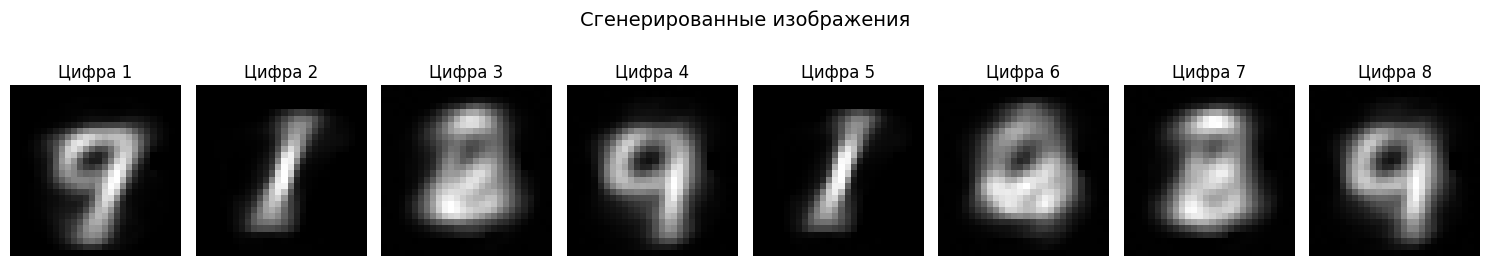

Эпоха  20/60 | Общая потеря:  4139.95 | Реконструкция:  3843.63 | KL:   296.33


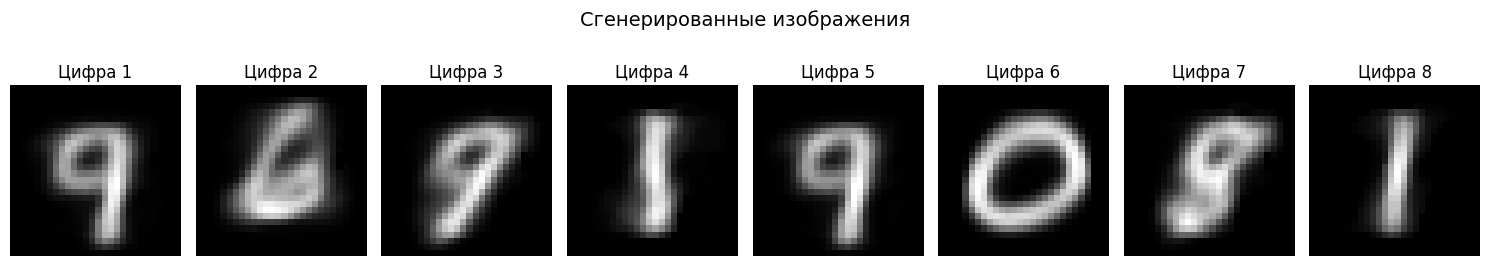

Эпоха  30/60 | Общая потеря:  3987.07 | Реконструкция:  3661.90 | KL:   325.17


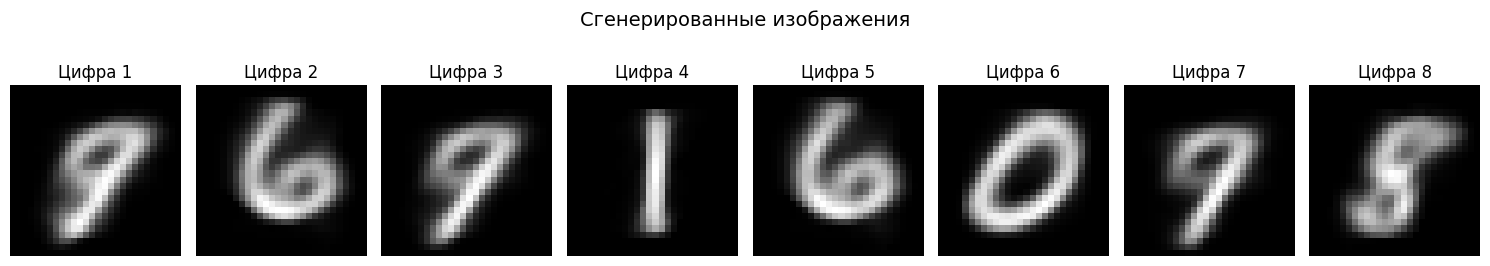

Эпоха  40/60 | Общая потеря:  3927.90 | Реконструкция:  3587.44 | KL:   340.46


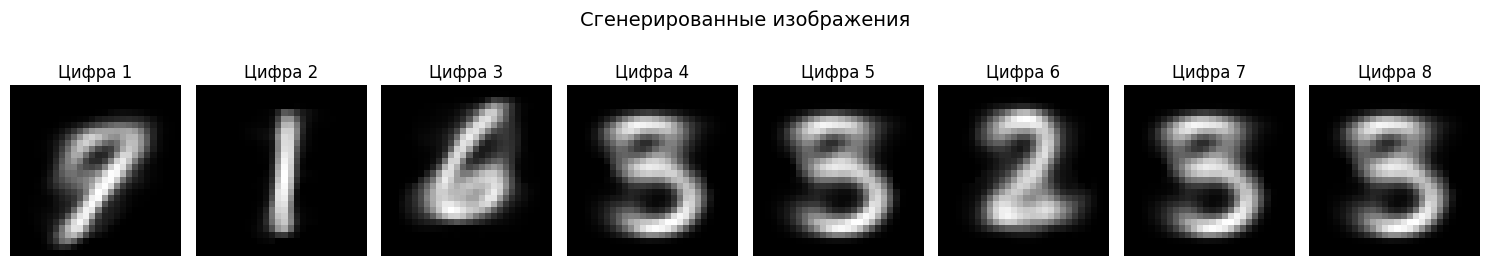

Эпоха  50/60 | Общая потеря:  3886.30 | Реконструкция:  3535.15 | KL:   351.15


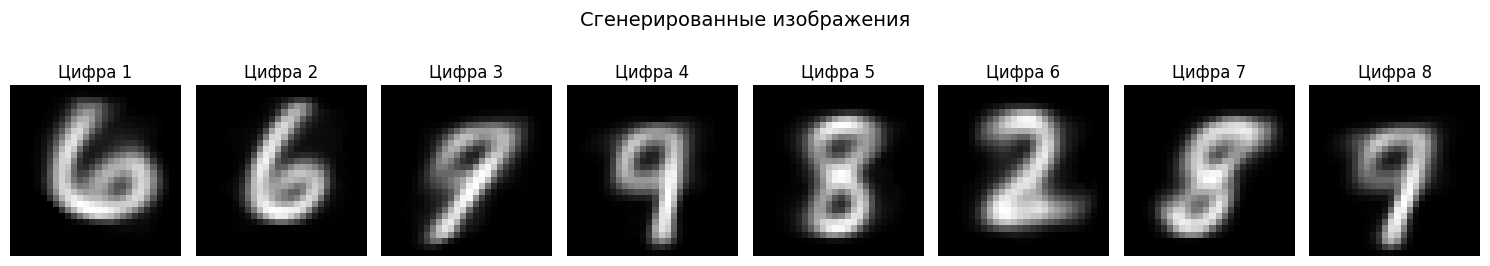

Эпоха  60/60 | Общая потеря:  3852.63 | Реконструкция:  3494.15 | KL:   358.48


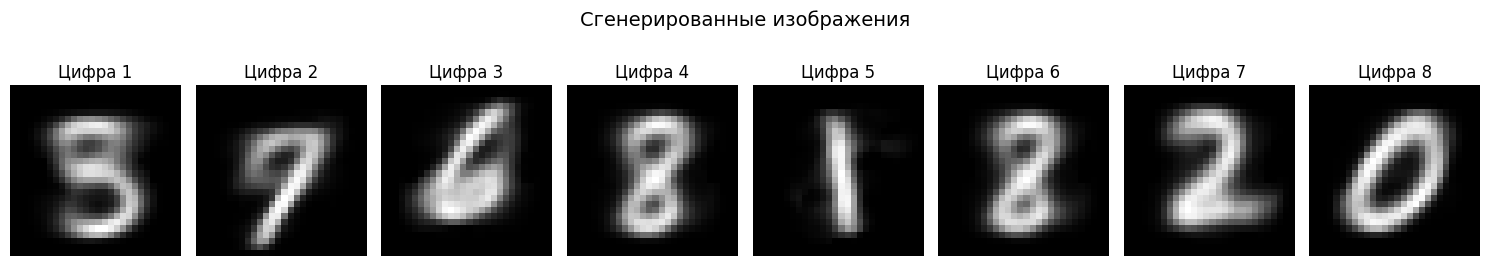

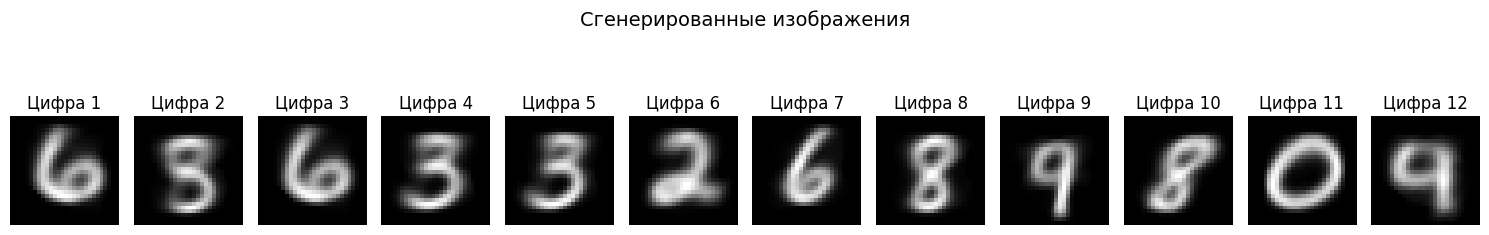

In [20]:
if __name__ == "__main__":
    main()